In [1]:
import numpy as np
from typing import Type, TypeVar
import matplotlib.pyplot as plt
from copy import deepcopy


def lambda_sum(w, lambd):
    return np.mean(lambd * w ** 2) / 2


def polynom(inputs: np.ndarray, degree=1):
    assert degree > 0
    if degree == 1:
        return inputs

    transposed = inputs.T
    base = len(transposed)

    pols = []
    newgen = []
    for i in range(base):
        newgen.append([i])
    pols.extend(newgen)

    for deg in range(1, degree):
        lastgen = newgen
        newgen = []
        for p in lastgen:
            for i in range(p[-1], base):
                pnext = [*p, i]
                pnext.sort()
                newgen.append(pnext)
        pols.extend(newgen)

    new_inputs = []
    for p in pols:
        new_inputs.append(deepcopy(transposed[p[0]]))
        for i in p[1:]:
            new_inputs[-1] *= transposed[i]
    return np.array(new_inputs).T

class Normalizer:
    """
    The Great Normalizer
    """
    mins: np.ndarray
    maxs: np.ndarray
    span: np.ndarray
    mids: np.ndarray

    def __init__(self, reference_inputs: np.ndarray):
        self.mins = np.min(reference_inputs, 0)
        self.maxs = np.max(reference_inputs, 0)
        self.span = self.maxs - self.mins
        # mids = span / 2 + mins
        # and thus:
        # mids = (maxs + mins) / 2
        self.mids = (self.maxs + self.mins) / 2

    def scale(self, set: np.ndarray):
        # k0 = (reference_inputs[0] - mids) / (span / 2)
        # and thus:
        # k0 = 2*(reference_inputs[0] - mids) / span
        return 2 * np.subtract(set, self.mids) / self.span


class ActivationManager():
    def activate(self, z: np.ndarray) -> np.ndarray:
        return np.array([])

    def derivate(self, a: np.ndarray) -> np.ndarray:
        return np.array([])

    def cost(self, predictions: np.ndarray, truth: np.ndarray, w=None, lambd=None) -> np.ndarray:
        return np.array([])


class SigmoidActivator(ActivationManager):
    def activate(self, z):
        return 1 / (1 + np.exp(-z))

    def derivate(self, a):
        return a * (1-a)

    def cost(self, predictions, truth, w=None, lambd=None):
        a = truth * np.log(predictions)
        b = (1 - truth) * np.log(1 - predictions)
        result = -np.mean(a+b)
        if w is not None and lambd:
            result += lambda_sum(w, lambd)
        return result


class LinearActivator(ActivationManager):
    def activate(self, z):
        return z

    def cost(self, predictions, truth, w=None, lambd=None):
        result = np.mean((predictions - truth)**2) / 2
        if w is not None and lambd:
            result += lambda_sum(w, lambd)
        return result

    def derivate(self, a):
        return 1


class SoftmaxActivator(ActivationManager):
    def activate(self, z):
        expz = np.exp(z)
        return expz / expz.sum(axis=1).reshape(-1,1)

    def cost(self, predictions, truth, w=None, lambd=None):
        result = np.sum(-np.log(predictions) * truth,axis=1)
        result = np.mean(result)
        if w is not None and lambd:
            result += lambda_sum(w, lambd)
        return result

    def derivate(self, a):
        return a-a**2


np.random.seed(1)
def generate_wb(units: int, inputs: int):
    w = 2 * np.random.random((inputs, units)) - 1
    b = 2 * np.random.random(units) - 1
    return w, b


TLayer = TypeVar("TLayer", bound="Layer")
class Layer():
    units: int

    def __init__(self, units: int, activator: ActivationManager, inputs: int | None = None):
        self.units = units
        if inputs is not None:
            self.compile(inputs=inputs)
        self.activator = activator

    def compile(self, inputs: int):
        assert inputs > 0
        self.W, self.B = generate_wb(units=self.units, inputs=inputs)
        return self

    def propagate(self, inputs):
        self.x = inputs
        self.m = len(inputs)
        z: np.ndarray = np.matmul(inputs, self.W) + self.B
        a: np.ndarray = self.activator.activate(z)
        self.a = a
        return a

    def __errback__(self) -> np.ndarray:
        return np.matmul(self.g, self.W.T)

    def backprop(self, next_l: TLayer = None, e=None):
        if e is None:
            assert next_l is not None
            e = next_l.__errback__()
        self.g: np.ndarray = self.activator.derivate(self.a) * e
        self.gw: np.ndarray = np.matmul(self.x.T, self.g) / self.m
        self.gb: np.ndarray = np.mean(self.g, axis=0)

    def adjust(self, alpha, lambd=0.):
        regularization_penalty = lambd * self.W / self.m if lambd is not None else 0
        self.W -= (self.gw + regularization_penalty) * alpha
        self.B -= self.gb * alpha

    def cost(self, y, lambd=0.):
        return self.activator.cost(
            lambd=lambd,
            w=self.W,
            predictions=self.a,
            truth=y
        )


class Sequence():
    layers: list[Layer] = []
    inputs: int | None = None

    def __init__(self, layers: list[Layer], alpha=1., lambd=0., inputs: int | None = None):
        assert len(layers) > 0
        self.layers = layers
        self.alpha = alpha
        self.lambd = lambd
        if inputs is not None:
            self.compile(inputs=inputs)

    def compile(self, inputs: int):
        assert inputs > 0
        self.inputs = inputs
        self.layers[0].compile(inputs=inputs)
        for l_prev, layer in zip(self.layers, self.layers[1:]):
            layer.compile(inputs=l_prev.units)
        return self

    def get_weights(self):
        weights = []
        for layer in self.layers:
            weights.append((layer.W, layer.B))

    def propagate(self, x: np.ndarray):
        self.layers[0].propagate(inputs=x)
        for l_prev, layer in zip(self.layers, self.layers[1:]):
            layer.propagate(inputs=l_prev.a)
        out = self.layers[-1].a
        return out

    def backprop(self, err: np.ndarray):
        self.layers[-1].backprop(e=err)
        for i in reversed(range(len(self.layers)-1)):
            self.layers[i].backprop(next_l=self.layers[i+1])

    def adjust(self):
        for layer in self.layers:
            layer.adjust(alpha=self.alpha, lambd=self.lambd)

    def test(self, x: np.ndarray, y: np.ndarray, lambd=0.):
        out = self.propagate(x=x)
        mse = np.mean((out-y)**2) / 2
        cost = self.layers[-1].cost(y=y, lambd=lambd)
        return cost, mse

    def fit_one(self, x: np.ndarray, y: np.ndarray):
        out = self.propagate(x=x)
        err = out - y
        self.backprop(err=err)
        self.adjust()
        return self.layers[-1].cost(y=y, lambd=self.lambd)

    def fit(self, x: np.ndarray, y: np.ndarray, times=10000, alpha=None, lambd=None):
        if alpha is not None:
            self.alpha = alpha
        if lambd is not None:
            self.lambd = lambd
        costs = []
        for _ in range(times):
            costs.append(self.fit_one(x, y))
        return costs


def generate_layers(units_per_layer: list[int], activator: ActivationManager, inputs: int | None = None):
    assert len(units_per_layer) > 0
    if inputs is not None:
        assert inputs > 0
    layers: list[Layer] = []
    layers.append(Layer(units=units_per_layer[0], activator=activator, inputs=inputs))
    for u_prev, units in zip(units_per_layer, units_per_layer[1:]):
        l_inputs = None if inputs is None else u_prev
        layers.append(Layer(units=units, activator=activator, inputs=l_inputs))
    return layers


In [2]:
# net = Sequence(
#     generate_layers(units_per_layer=[5, 6, 1],
#                     activator=SigmoidActivator(),
#                     inputs=3
#                     )
# )
# Results at classification examples:
training_data = np.array([
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 1, 1, 0, 1],
    [1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 1, 0],
    [1, 1, 1, 1, 0]
])
x_train = training_data[:, :3]
y_train = training_data[:, 3:]
# x_cv = training_data[:-1, :3]
# y_cv = training_data[:-1, 3:]
# rms 1.994458755690915e-06:
# net = Sequence([
#     Layer(5, LinearActivator()),
#     Layer(6, LinearActivator()),
#     Layer(2, SoftmaxActivator()),
# ]).compile(3)
# rms 6.113094236479525e-30:
# net = Sequence([
#     Layer(5, LinearActivator()),
#     Layer(6, LinearActivator()),
#     Layer(2, LinearActivator()),
# ],
#     alpha=0.1,
# ).compile(3)
# rms 1.5195036869673113e-06:
# net = Sequence([
#     Layer(5, LinearActivator()),
#     Layer(6, LinearActivator()),
#     Layer(2, SigmoidActivator()),
# ]).compile(3)
# rms 5.9855255986468014e-05:
# net = Sequence([
#     Layer(5, SigmoidActivator()),
#     Layer(6, SigmoidActivator()),
#     Layer(2, SigmoidActivator()),
# ]).compile(3)
# rms 4.257827368312353e-05:
net = Sequence([
    Layer(5, SigmoidActivator()),
    Layer(6, SigmoidActivator()),
    Layer(2, SoftmaxActivator()),
]).compile(3)

# Results at regression examples:
# dataset = np.array([
#     [2104, 5, 1, 45, 460],
#     [1416, 3, 2, 40, 232],
#     [1534, 3, 2, 30, 315],
#     [1600, 4, 2, 30, 389],
#     [852, 2, 1, 36, 178],
# ])
# x_train = dataset[:, :-1]
# normer = Normalizer(x_train)
# x_train = normer.scale(x_train)
# y_train = dataset[:, -1:]
# rms 4.1359030627651386e-26:
# net = Sequence([
#     Layer(5, LinearActivator()),
#     Layer(6, LinearActivator()),
#     Layer(1, LinearActivator()),
# ],alpha=.0001).compile(4)

costs = []


In [3]:
costs_by_labmda = []
lambdas = np.array([0, 1,2,4,8,16,32,64,128,256,512,1024]) / 100
for lambd in lambdas:
    cost_by_labmda = net.fit(x_train,y_train,lambd=lambd)
    costs_by_labmda.append(cost_by_labmda)


# plt.plot(costs)
# plt.grid(True)
# plt.yscale('log')
# plt.title(f"{costs[-1]}")
# plt.show()
# y_out = net.propagate(x_train)
# print(y_out)
# print(np.mean((y_out-y_train)**2))
# # print()


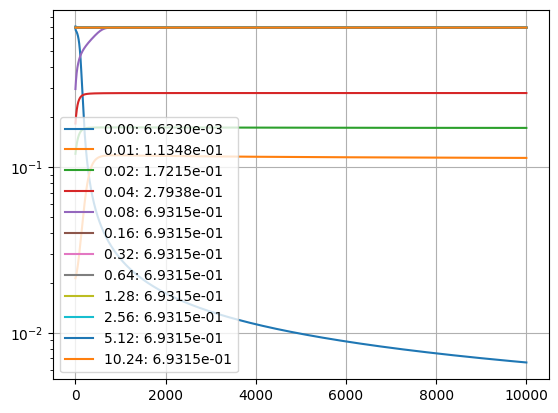

In [7]:
# rcost, rmse = net.test(x_train[0:5,:], y_train[0:5,:])

for i in range(len(costs_by_labmda)):
    plt.plot(costs_by_labmda[i], label=f"{lambdas[i]:.2f}: {costs_by_labmda[i][-1]:.4e}")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()
# fig = plt.figure(figsize=(4, 3))
# gs = fig.add_gridspec(3, 4)  # hspace=0, wspace=0
# a = gs.subplots()
# af: list[plt.Axes] = a.flatten()
# for ax, costs in zip(af,cost_by_labmda):
#     ax.plot(costs)
#     ax.grid(True)
# plt.show()
